In [1]:
# !pip install gurobipy

In [2]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import networkx as nx
from skimage import color
from sklearn.feature_extraction import image
import math
import pandas as pd

In [3]:
pixel_data = pd.read_csv('oval-1.csv', delimiter=',')
data2 = pd.read_csv('box.csv',delimiter=',')
example_df = pd.DataFrame([[100, 120, 120],
                           [90, 100, 130],
                           [80, 85, 125]])

In [4]:
# Your given 20x20 intensity matrix
def a(pixel_data,threshold,sigma):
    intensity_matrix = pixel_data
    # Define image size and total nodes including source and sink
    image_size = intensity_matrix.shape[0] 
    num_nodes = image_size * image_size + 2  # Including source and sink

    # Set sigma value
    # sigma = 0.05# Experiment with this value

    # Create a network matrix of size 402x402
    network = np.zeros((num_nodes, num_nodes))

    # Calculate similarity values for connected pixels
    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            Ii = intensity_matrix.iloc[i, j]

            # Horizontal neighbors
            if j < image_size - 1:
                neighbor = pixel + 1
                Ij = intensity_matrix.iloc[i, j + 1]
                similarity = 100 * math.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))
                similarity = math.ceil(similarity)
                network[pixel, neighbor] = similarity
                network[neighbor, pixel] = similarity

            # Vertical neighbors
            if i < image_size - 1:
                neighbor = pixel + image_size
                Ij = intensity_matrix.iloc[i + 1, j]
                similarity = 100 * math.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))
                similarity = math.ceil(similarity)
                network[pixel, neighbor] = similarity
                network[neighbor, pixel] = similarity

    # Adding connections for the source (node 400) and sink (node 401)
    source_node = 0
    sink_node = num_nodes - 1

    # Update connections for source and sink
    # Assuming values closer to 0 belong to the foreground (oval)
    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            if intensity_matrix.iloc[i, j] < threshold:  # Adjust this threshold for your image
                network[source_node, pixel] = 100  # Strong connection to source
            else:
                network[pixel, sink_node] = 100 # Strong connection to sink
    
    return network, intensity_matrix


In [5]:
def b(network,intensity_matrix):
    # Create the Gurobi model
    mod = gp.Model("max_flow_image_segmentation")
    num_nodes = network.shape[0]
    source_node = 0
    sink_node = num_nodes - 1
    image_size = intensity_matrix.shape[0] 

    # Add the matrix of decision variables with an upper bound defined by the network matrix
    flow = mod.addMVar((num_nodes, num_nodes), ub=network, vtype=gp.GRB.CONTINUOUS, name="flow")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(flow[source_node, :].sum(), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            mod.addConstr(flow[:, node].sum() == flow[node, :].sum(), name=f"flow_conservation_{node}")
    mod.Params.OutputFlag = 0 
    # Solve the model
    mod.optimize()
    # Checking if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found")
        flow_solution = flow.X  # Get the values of decision variables

        # Calculate the residual network
        residual_network = network - flow_solution
        
        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)

        # Find the cut edges
        cut_edges = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if visited[i] and not visited[j] and network[i, j] > 0:
                    cut_edges.append((i, j))

        # Visualize the segmentation
        plt.imshow(intensity_matrix, cmap='gray', vmin=0, vmax=1)
        print(cut_edges)
        # Overlay the cuts in red
        for i, j in cut_edges:
            
            if i < image_size * image_size and j < image_size * image_size:
                row_i, col_i = divmod(i, image_size)
                row_j, col_j = divmod(j, image_size)
                # plt.plot([col_i - 0.5, col_j - 0.5], [row_i + 0.5, row_j + 0.5], color='red', linewidth=1)
                plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

        plt.title("Segmented Image with Cuts")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("No optimal solution found")

In [6]:
networkk, intensity_matrixx = a(data2,threshold=0.3,sigma = 0.1)
networkk

array([[100., 100., 100., ...,   0.,   0.,   0.],
       [100.,   0., 100., ...,   0.,   0.,   0.],
       [  0., 100.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 100.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26
Optimal solution found
[(182, 201), (183, 202), (184, 203), (185, 204), (186, 205), (187, 206), (188, 207), (188, 362), (189, 208), (189, 362), (200, 201), (219, 220), (238, 239), (257, 258), (276, 277), (295, 296), (314, 315), (314, 362), (333, 334), (333, 362), (351, 362), (352, 353), (352, 362)]


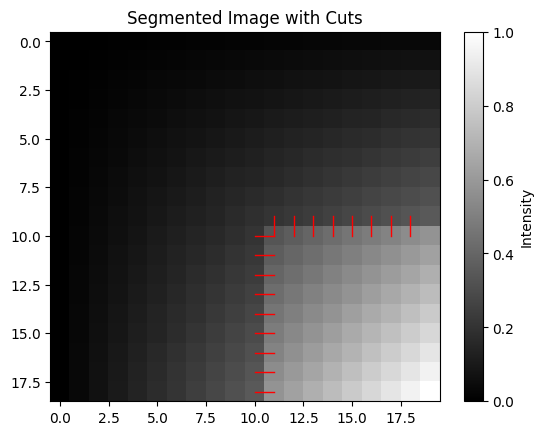

In [7]:
b(network=networkk,intensity_matrix=intensity_matrixx)

In [8]:
from PIL import Image

# Open the image
image_path = "Pelican.jpg"  # Replace with your image path
img = Image.open(image_path)

# Convert image to grayscale
grayscale_img = img.convert("L")

# Get pixel values as a 2D array
pixel_table = list(grayscale_img.getdata())
width, height = grayscale_img.size
pixel_table = [pixel_table[i * width:(i + 1) * width] for i in range(height)]

#the image is a 128*128 matrix
# Display the pixel table
# for row in pixel_table:
#     print(row)

pixel_df = pd.DataFrame(pixel_table)
# pixel_df

In [9]:
networkk2, intensity_matrixx2 = a(pixel_df,threshold=0.3,sigma = 0.1)
networkk2

array([[  0., 100.,   0., ...,   0.,   0., 100.],
       [100.,   0., 100., ...,   0.,   0., 100.],
       [  0., 100.,   0., ...,   0.,   0., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 100.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [10]:
# b(network=networkk2,intensity_matrix=intensity_matrixx2)

KeyboardInterrupt: 